With this code, we take in BC data (saved at 64 points wide by 64 points tall) and trim it to a smaller size that can be use to train a Palette DM.

In [1]:
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from shutil import copy

In [2]:
## User inputs
## General parameters
jwidth_lidar = 20
zlidar = 115  
klidar_global = 11  
dy_amr = 10   # m, AMR-Wind grid resolution
dz_amr = 10   # m, AMR-Wind grid resolution

## Input data parameters
parent_dir_in = Path('/scratch/orybchuk/wakedynamics/bcs-ldm/data/072415/post_processing/inflow-bc-3D/npy_blocks256')
parent_parent_dir_out = Path('/scratch/orybchuk/wakedynamics/bcs-ldm/palette_3d/datasets/072415')
parent_parent_dir_out.mkdir(exist_ok=True, parents=True)

# Info about the cube of data
nchan_in = 5
ntime_in = 256
nj_in = 64
nk_in = 64

nchan_out = 5
if nchan_out == 1: print("Because nchan_out=1, assume that we're saving out u")

### CASCADING STRATEGIES WHERE WE EXPAND TO 32-WIDE THROUGH DIFFUSERS (uncomment as needed)
## Denoised, 32-wide lidar data --> 4-tall
tlo_in_global = 0
thi_in_global = 256
jlo_in_global = 16  # 54 = 128/2 - 10; 22 = 64/2 - 10
jhi_in_global = 48  # 75 = 128/2 + 11; 43 = 64/2 + 11
klo_in_global = 11
khi_in_global = 12

tlo_out_global = 0
thi_out_global = 256
jlo_out_global = 16
jhi_out_global = 48
klo_out_global = 8
khi_out_global = 12

# ## 4 tall --> 12-tall
# tlo_in_global = 0
# thi_in_global = 256
# jlo_in_global = 16  # 54 = 128/2 - 10; 22 = 64/2 - 10
# jhi_in_global = 48  # 75 = 128/2 + 11; 43 = 64/2 + 11
# klo_in_global = 8
# khi_in_global = 12

# tlo_out_global = 0
# thi_out_global = 256
# jlo_out_global = 16
# jhi_out_global = 48
# klo_out_global = 0
# khi_out_global = 12

# ## 12 tall --> 24-tall
# tlo_in_global = 0
# thi_in_global = 256
# jlo_in_global = 16  # 54 = 128/2 - 10; 22 = 64/2 - 10
# jhi_in_global = 48  # 75 = 128/2 + 11; 43 = 64/2 + 11
# klo_in_global = 0
# khi_in_global = 12

# tlo_out_global = 0
# thi_out_global = 256
# jlo_out_global = 16
# jhi_out_global = 48
# klo_out_global = 0
# khi_out_global = 24

In [3]:
### Check input values
assert nchan_out <= nchan_in
assert ntime_in >= thi_out_global-tlo_out_global
assert nj_in >= jhi_out_global-jlo_out_global
assert nk_in >= khi_out_global-klo_out_global

assert jlo_in_global <= nj_in
assert jhi_in_global <= nj_in
assert klo_in_global <= nk_in
assert khi_in_global <= nk_in

# Assert that our output is growing and not shrinking
assert jlo_out_global <= jlo_in_global
assert jhi_out_global >= jhi_in_global
assert klo_out_global <= klo_in_global
assert khi_out_global >= khi_in_global

In [4]:
### Calculate relative indices
# Calculate the relative position of input data to the trimmed box
tlo_in_rel = tlo_in_global - tlo_out_global
thi_in_rel = tlo_in_rel + thi_in_global - tlo_in_global
jlo_in_rel = jlo_in_global - jlo_out_global
jhi_in_rel = jlo_in_rel + jhi_in_global - jlo_in_global
klo_in_rel = klo_in_global - klo_out_global
khi_in_rel = klo_in_rel + khi_in_global - klo_in_global

# Calculate the relative indices of the output box
tlo_out_rel = 0
thi_out_rel = tlo_out_rel + thi_out_global - tlo_out_global
jlo_out_rel = 0
jhi_out_rel = jlo_out_rel + jhi_out_global - jlo_out_global
klo_out_rel = 0
khi_out_rel = klo_out_rel + khi_out_global - klo_out_global

print("Size of input data:")
print(jhi_in_global-jlo_in_global, khi_in_global-klo_in_global)
print("Size of output data:")
print(jhi_out_global-jlo_out_global, khi_out_global-klo_out_global)
print("Indices of relative input data within the trimmed box:")
print("jlo_in_rel, jhi_in_rel, klo_in_rel, khi_in_rel:", jlo_in_rel, jhi_in_rel, klo_in_rel, khi_in_rel)

# outbox = np.zeros((thi_out_rel, jhi_out_rel, khi_out_rel))

Size of input data:
32 1
Size of output data:
32 4
Indices of relative input data within the trimmed box:
jlo_in_rel, jhi_in_rel, klo_in_rel, khi_in_rel: 0 32 3 4


In [5]:
### Create dataframe that saves all the stats
hyperparam_cols = ['nchan_in', 'ntime_in', 'nj_in', 'nk_in',
                   'jlo_in_global', 'jhi_in_global', 'klo_in_global', 'khi_in_global',
                   'tlo_in_rel', 'thi_in_rel',
                   'jlo_in_rel', 'jhi_in_rel', 'klo_in_rel', 'khi_in_rel',
                   'nchan_out', 'tlo_out_global', 'thi_out_global',
                   'tlo_out_rel', 'thi_out_rel',
                   'jlo_out_global', 'jhi_out_global', 'klo_out_global', 'khi_out_global',
                   'jlo_out_rel', 'jhi_out_rel', 'klo_out_rel', 'khi_out_rel']
hyperparam_data = np.array([nchan_in, ntime_in, nj_in, nk_in,
                   jlo_in_global, jhi_in_global, klo_in_global, khi_in_global,
                   tlo_in_rel, thi_in_rel,
                   jlo_in_rel, jhi_in_rel, klo_in_rel, khi_in_rel,
                   nchan_out, tlo_out_global, thi_out_global,
                   tlo_out_rel, thi_out_rel,
                   jlo_out_global, jhi_out_global, klo_out_global, khi_out_global,
                   jlo_out_rel, jhi_out_rel, klo_out_rel, khi_out_rel])[np.newaxis,:]
hyperparam_df = pd.DataFrame(hyperparam_data, columns=hyperparam_cols)

In [6]:
### Create the output directories
###   Abort this script if these directories exists
## Create output parent directory
parent_dir_out = Path(parent_parent_dir_out,
                      f'time{thi_out_global}_chan{nchan_out}_j{jlo_in_global}_{jhi_in_global}_{jlo_out_global}_{jhi_out_global}_k{klo_in_global}_{khi_in_global}_{klo_out_global}_{khi_out_global}')
parent_dir_out.mkdir(exist_ok=True)
parent_dir_empty = not any(parent_dir_out.iterdir())
if not parent_dir_empty:
    raise FileExistsError(f"The output directory {parent_dir_out} already exists and is populated! You likely don't need to run this script again for this configuration")

## Get input subdirectoties (likely 'test', 'train', 'val')
input_subdirs = [f for f in parent_dir_in.iterdir() if f.is_dir()]

In [7]:
### Copy over velocity statistics file
copy(Path(parent_dir_in, 'stats.txt'), parent_dir_out)

'/scratch/orybchuk/wakedynamics/bcs-ldm/palette_3d/datasets/072415/time256_chan5_j16_48_16_48_k11_12_8_12/stats.txt'

In [8]:
### Create and save mask files
## Create mask array
# Mask 1 assumes no prior conditioning at this size
mask_shape = (thi_out_rel, jhi_out_rel, khi_out_rel, nchan_out)
mask_cascade1 = np.ones((mask_shape))  # 1 = masked, 0 = observed with Palette
# if klo_out_global == 8:
# if (khi_in_global - klo_in_global) == 1:
#     print("WARNING: ASSUMING THIS NETWORK SEES RAW LIDAR MEASUREMENTS")
#     print("AS SUCH, IT WILL BE CONDITIONED ON ONLY U DATA")
#     mask_cascade1[tlo_in_rel:thi_in_rel,jlo_in_rel:jhi_in_rel,klo_in_rel:khi_in_rel,0] = 0  # ASSUME: Only ever show u
# else:
print("WARNING: ASSUMING THIS NETWORK SEES SMALLER, INPAINTED RECONSTRUCTIONS")
print("AS SUCH, IT WILL BE CONDITIONED ON DATA IN ALL CHANNELS")
mask_cascade1[tlo_in_rel:thi_in_rel,jlo_in_rel:jhi_in_rel,klo_in_rel:khi_in_rel,:] = 0  # ASSUME: 5 chan networks will be given 

    
# Mask 2 assumes half of the input array is already populated
mask_cascade2 = mask_cascade1.copy()
tmp_halftime = int(tlo_in_rel + (thi_in_rel-tlo_in_rel)/2)
mask_cascade2[tlo_in_rel:tmp_halftime,:,:,:] = 0

## Save masks
mask_dir = Path(parent_dir_out, 'masks')
mask_dir.mkdir(exist_ok=True)

np.save(Path(mask_dir, 'mask_cascade1.npy'), mask_cascade1)
np.save(Path(mask_dir, 'mask_cascade2.npy'), mask_cascade2)

AS SUCH, IT WILL BE CONDITIONED ON DATA IN ALL CHANNELS


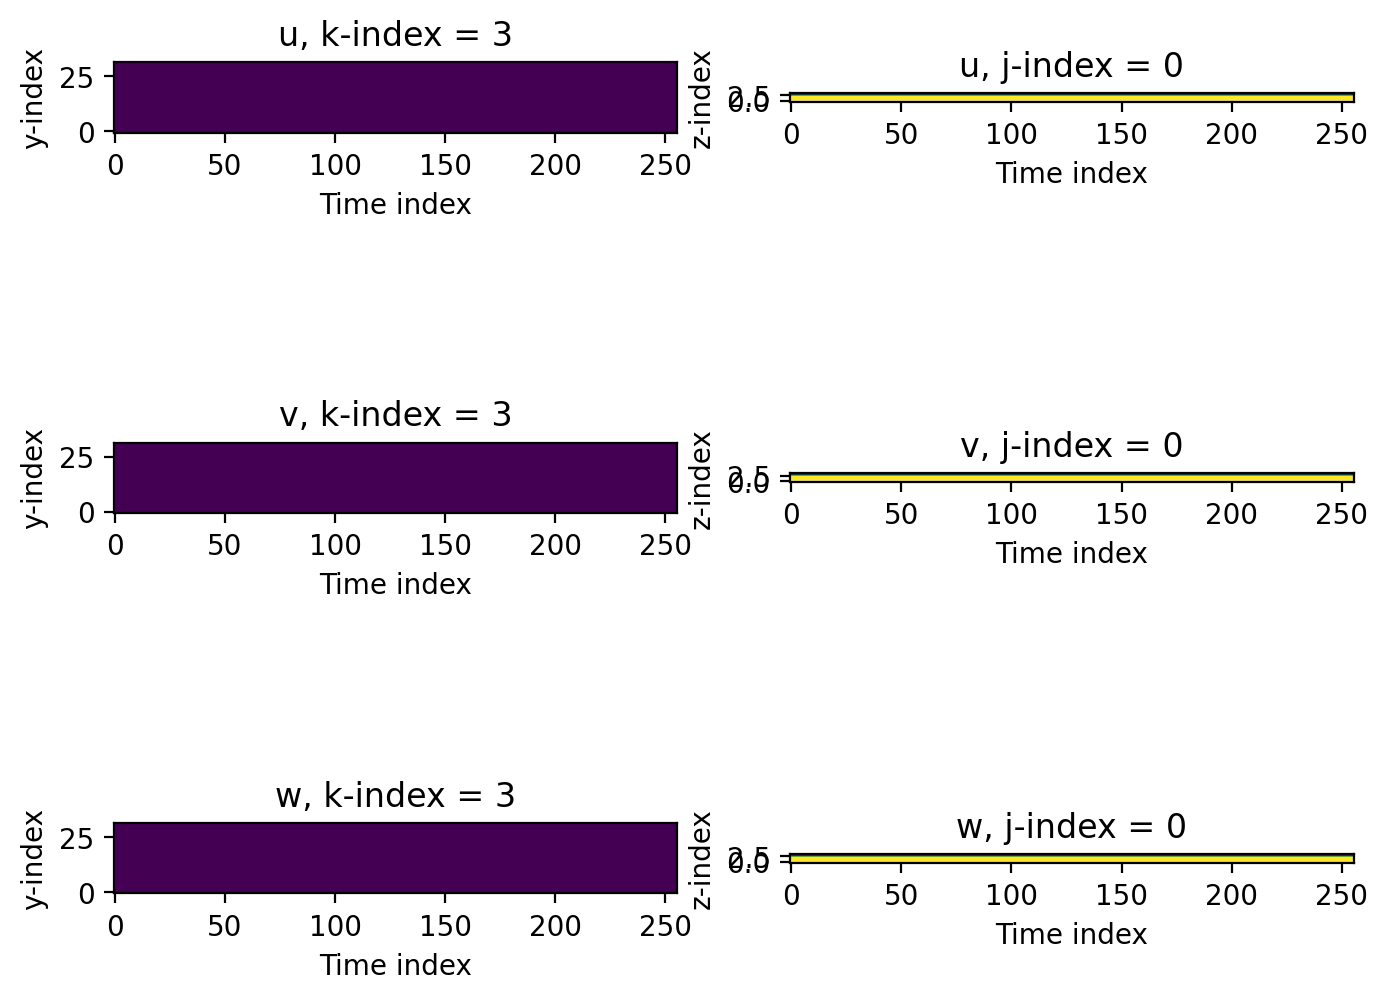

In [42]:
## Save out one demo sample
fig, ax = plt.subplots(3, 2, figsize=(8, 7), dpi=200)

pltmin = 0
pltmax = 1

pltarr = mask_cascade1

## Plot
# Top-down view
kplt = klo_in_rel
ax[0,0].imshow(pltarr[:,:,kplt,0].T,
             origin='lower',
             vmin=pltmin,
             vmax=pltmax)
ax[0,0].set_xlabel('Time index')
ax[0,0].set_ylabel('y-index')
ax[0,0].set_title(f'u, k-index = {kplt}')

ax[1,0].imshow(pltarr[:,:,kplt,1].T,
             origin='lower',
             vmin=pltmin,
             vmax=pltmax)
ax[1,0].set_xlabel('Time index')
ax[1,0].set_ylabel('y-index')
ax[1,0].set_title(f'v, k-index = {kplt}')

ax[2,0].imshow(pltarr[:,:,kplt,2].T,
             origin='lower',
             vmin=pltmin,
             vmax=pltmax)
ax[2,0].set_xlabel('Time index')
ax[2,0].set_ylabel('y-index')
ax[2,0].set_title(f'w, k-index = {kplt}')

# Side view
jplt = jlo_in_rel
ax[0,1].imshow(pltarr[:,jplt,:,0].T,
             origin='lower',
             vmin=pltmin,
             vmax=pltmax)
ax[0,1].set_xlabel('Time index')
ax[0,1].set_ylabel('z-index')
ax[0,1].set_title(f'u, j-index = {jplt}')

ax[1,1].imshow(pltarr[:,jplt,:,1].T,
             origin='lower',
             vmin=pltmin,
             vmax=pltmax)
ax[1,1].set_xlabel('Time index')
ax[1,1].set_ylabel('z-index')
ax[1,1].set_title(f'v, j-index = {jplt}')

ax[2,1].imshow(pltarr[:,jplt,:,2].T,
             origin='lower',
             vmin=pltmin,
             vmax=pltmax)
ax[2,1].set_xlabel('Time index')
ax[2,1].set_ylabel('z-index')
ax[2,1].set_title(f'w, j-index = {jplt}')
    
plt.show()

2024-07-03 09:06:29.490427 Creating /scratch/orybchuk/wakedynamics/bcs-ldm/palette_3d/datasets/072415/time256_chan5_j16_48_16_48_k11_12_8_12/test ...
2024-07-03 09:06:29.493544 Populating /scratch/orybchuk/wakedynamics/bcs-ldm/palette_3d/datasets/072415/time256_chan5_j16_48_16_48_k11_12_8_12/test ...
2024-07-03 09:07:09.049500 Creating /scratch/orybchuk/wakedynamics/bcs-ldm/palette_3d/datasets/072415/time256_chan5_j16_48_16_48_k11_12_8_12/train ...
2024-07-03 09:07:09.065809 Populating /scratch/orybchuk/wakedynamics/bcs-ldm/palette_3d/datasets/072415/time256_chan5_j16_48_16_48_k11_12_8_12/train ...
2024-07-03 09:22:08.506960 Done!


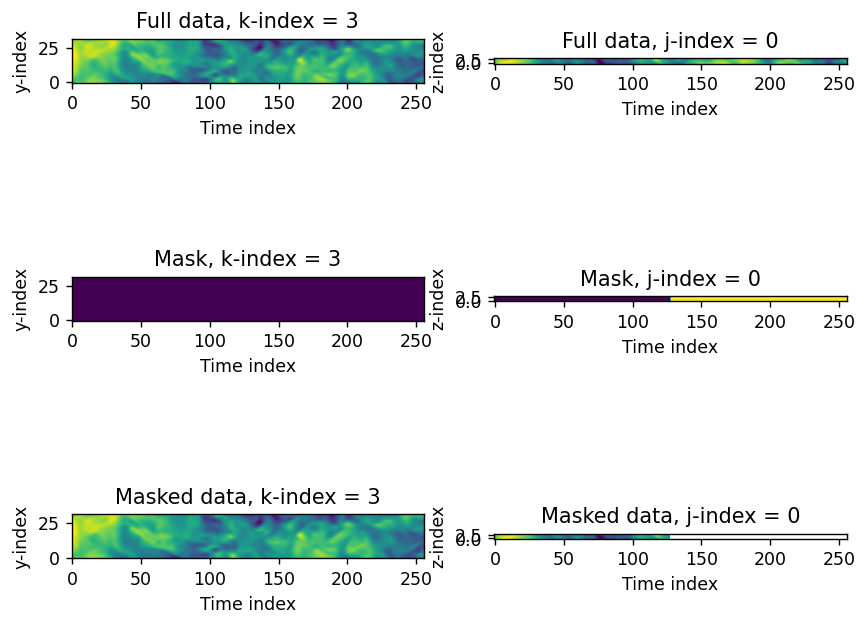

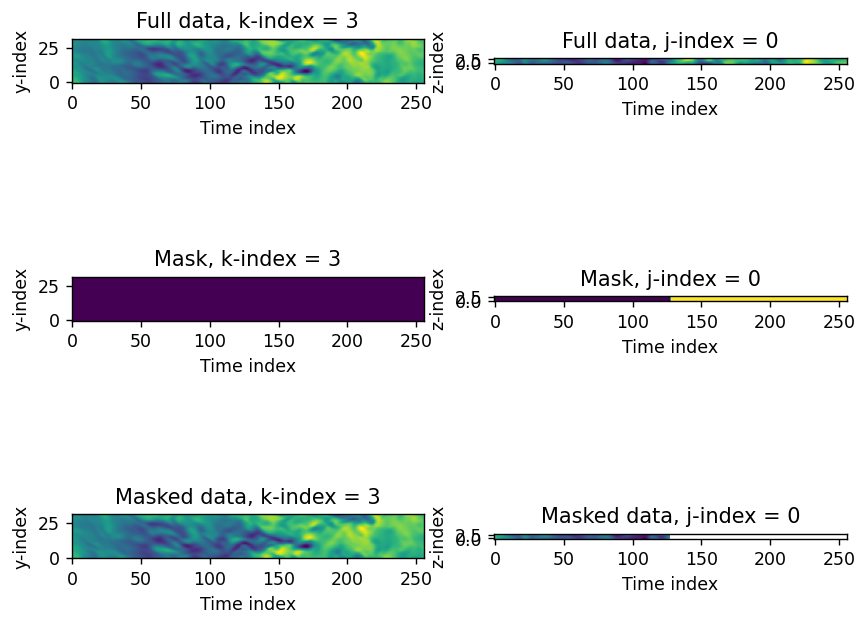

In [21]:
### Populate input subdirectories with data
for input_subdir in input_subdirs:
    ## Create output subdirectory
    output_subdir = Path(parent_dir_out, input_subdir.name)
    print(f"{datetime.now()} Creating {output_subdir} ...")
    output_subdir.mkdir(exist_ok=True)

    ## Prepare to read in data
    in_files = list(input_subdir.glob('*.npy'))
    in_files.sort()
    
    ## Read in, trim, and write out data
    print(f"{datetime.now()} Populating {output_subdir} ...")
    for f_in in in_files:
        arr_in = np.load(f_in)
        assert arr_in.shape == (nchan_in, ntime_in, nj_in, nk_in), \
            f"Expected shape of arr_in to be {(nchan_in, ntime_in, nj_in, nk_in)}, but it was {arr_in.shape}"
        
        if nchan_out == 1:
            arr_out = arr_in[0, tlo_out_global:thi_out_global, jlo_out_global:jhi_out_global, klo_out_global:khi_out_global]
            arr_out = arr_out[np.newaxis, :, :, :]
        else:
            arr_out = arr_in[:nchan_out, tlo_out_global:thi_out_global, jlo_out_global:jhi_out_global, klo_out_global:khi_out_global]
            
        f_out = Path(output_subdir, f_in.name)
        np.save(f_out, arr_out)
        hyperparam_df.to_csv(Path(output_subdir, 'hyperparameters.csv'))
        
    ## Create corresponding flist
    flist_dir = Path(parent_dir_out, 'flist')
    flist_dir.mkdir(exist_ok=True)
    flist_file = Path(flist_dir, f'{input_subdir.name}.flist')

    with open(flist_file, 'w') as f:
        for f_in in in_files:
            line = str(output_subdir)+'/'+f_in.name+'\n'
            f.write(line)
        
    ## Save out one demo image
    fig, ax = plt.subplots(3, 2, figsize=(8, 7), dpi=125)

    nan_mask = mask_cascade2.copy()
    nan_mask[nan_mask==1] = np.nan
    nan_mask += 1

    ## Plot
    # Top-down view
    kplt = klo_in_rel
    ax[0,0].imshow(arr_out[0,:,:,kplt].T,
                 origin='lower')
    ax[0,0].set_xlabel('Time index')
    ax[0,0].set_ylabel('y-index')
    ax[0,0].set_title(f'Full data, k-index = {kplt}')

    ax[1,0].imshow(mask_cascade2[:,:,kplt,0].T,
                 origin='lower',
                 vmin=0,
                 vmax=1)
    ax[1,0].set_xlabel('Time index')
    ax[1,0].set_ylabel('y-index')
    ax[1,0].set_title(f'Mask, k-index = {kplt}')

    ax[2,0].imshow(nan_mask[:,:,kplt,0].T*arr_out[0,:,:,kplt].T,
                 origin='lower')
    ax[2,0].set_xlabel('Time index')
    ax[2,0].set_ylabel('y-index')
    ax[2,0].set_title(f'Masked data, k-index = {kplt}')

    # Side view
    jplt = jlo_in_rel
    ax[0,1].imshow(arr_out[0,:,jplt,:].T,
                 origin='lower')
    ax[0,1].set_xlabel('Time index')
    ax[0,1].set_ylabel('z-index')
    ax[0,1].set_title(f'Full data, j-index = {jplt}')

    ax[1,1].imshow(mask_cascade2[:,jplt,:,0].T,
                 origin='lower',
                 vmin=0,
                 vmax=1)
    ax[1,1].set_xlabel('Time index')
    ax[1,1].set_ylabel('z-index')
    ax[1,1].set_title(f'Mask, j-index = {jplt}')

    ax[2,1].imshow(nan_mask[:,jplt,:,0].T*arr_out[0,:,jplt,:].T,
                 origin='lower')
    ax[2,1].set_xlabel('Time index')
    ax[2,1].set_ylabel('z-index')
    ax[2,1].set_title(f'Masked data, j-index = {jplt}')

    plt.savefig(Path(Path(output_subdir, 'demo_sample.png')), bbox_inches='tight')
print(f"{datetime.now()} Done!")